In [2]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
from matplotlib.animation import FuncAnimation
from numba import jit
from scipy.spatial.distance import cdist
from sklearn.preprocessing import normalize
%matplotlib inline
from IPython.display import HTML
from matplotlib.colors import Normalize

# MIC periodic distance

def periodic_distance(pos, box_size):
    dif=pos-pos[:,None]
    return np.sqrt(np.sum(dif ** 2,axis=-1))

def angle_between(point1, point2, dir1):
    v1 = dir1
    v2 = (point2 - point1)
    norm1 = np.linalg.norm(v1, axis=-1)
    norm2 = np.linalg.norm(v2, axis=-1)
    zero_mask1 = (norm1 == 0)
    zero_mask2=(norm2 == 0)
    norm1[zero_mask1] = 1
    norm2[zero_mask2] = 1
    cos_angles = np.sum(v1 * v2, axis=-1) / (norm1 * norm2)
    cos_angles = np.clip(cos_angles, -1.0, 1.0)
    return np.arccos(cos_angles)


def field_of_perception(pos_array, dir_array, interior_angle,L,dim):
    angles = angle_between(pos_array[:, None], pos_array[None, :],np.reshape(np.tile(dir_array[:, None, :], (1, N, 1)), (N, N, dim)))

    mask = (angles <= interior_angle)
    mask[np.isnan(angles)] = False
    return mask

def tendency(pos_matrix, pos_array,mask,L,dim):
    dif = (pos_matrix - pos_array.reshape(N, 1, dim))
    dif*=mask[:, :, np.newaxis]

    squared_dir_matrix = dif ** 2
    squared_sum = squared_dir_matrix.sum(axis=-1)
    norm_v = np.zeros_like(dif)

    nonzero_mask = squared_sum != 0
    norm_v[nonzero_mask] = dif[nonzero_mask] / np.sqrt(squared_sum[nonzero_mask])[:, np.newaxis]

    norm_v[np.isnan(norm_v)] = 0
    norm_v *= mask[:, :, np.newaxis]
    dr = np.sum(norm_v, axis=1)
    return normalize(dr, axis=1, norm='l2')


def align(dir_matrix,mask,pos_array,L):
    squared_dir_matrix = dir_matrix ** 2
    squared_sum = squared_dir_matrix.sum(axis=-1)
    norm_v = np.zeros_like(dir_matrix)

    nonzero_mask = squared_sum != 0
    norm_v[nonzero_mask] = dir_matrix[nonzero_mask] / np.sqrt(squared_sum[nonzero_mask])[:, np.newaxis]

    norm_v[np.isnan(norm_v)] = 0
    norm_v*=mask[:, :, np.newaxis]
    dr=np.sum(norm_v, axis=1)
    return normalize(dr, axis=1, norm='l2')

def neighbor(pos_array, radius_down, radius_up):
    dist = periodic_distance(pos_array,L)
    neighbors = np.logical_and(radius_down < dist, dist < radius_up)
    return neighbors

def rotate_vector(v1, v2, theta,dim):
    if dim == 3:
        axis = np.cross(v1, v2)
        axis = axis / np.linalg.norm(axis)
        angle = theta
        rot_matrix = np.array([[np.cos(angle) + axis[0] ** 2 * (1 - np.cos(angle)),
                                axis[0] * axis[1] * (1 - np.cos(angle)) - axis[2] * np.sin(angle),
                                axis[0] * axis[2] * (1 - np.cos(angle)) + axis[1] * np.sin(angle)],
                                [axis[1] * axis[0] * (1 - np.cos(angle)) + axis[2] * np.sin(angle),
                                np.cos(angle) + axis[1] ** 2 * (1 - np.cos(angle)),
                                axis[1] * axis[2] * (1 - np.cos(angle)) - axis[0] * np.sin(angle)],
                                [axis[2] * axis[0] * (1 - np.cos(angle)) - axis[1] * np.sin(angle),
                                axis[2] * axis[1] * (1 - np.cos(angle)) + axis[0] * np.sin(angle),
                                np.cos(angle) + axis[2] ** 2 * (1 - np.cos(angle))]])
        v = np.squeeze(normalize([rot_matrix.dot(v1)],'l2'))

        return v
    else:

        v1_unit = v1 / np.linalg.norm(v1)
        v2_unit = v2 / np.linalg.norm(v2)

        det = v1_unit[0]*v2_unit[1] - v1_unit[1]*v2_unit[0]
        direction = np.sign(det)
        theta = theta if direction >= 0 else -theta
        rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta),  np.cos(theta)]])
        v_rotated = np.dot(rot_matrix, v1_unit)
    
        return v_rotated



def turning(new_dir_array, dir_array, turning_rate,dim):
    angles=angle_between(np.zeros((N,dim)), dir_array, new_dir_array)
    mask=angles<turning_rate * dt
    indexs=np.squeeze(np.argwhere(mask == False))
    for i in indexs:
        new_dir_array[i] = rotate_vector(dir_array[i], new_dir_array[i], turning_rate * dt, dim)
    return new_dir_array


def update(pos_array, dir_array, rr, ro, ra, turning_rate,L,dim,status):
    stay=np.where(status==0)[0]
    leave=np.where(status==1)[0]
    arrive=np.where(status==2)[0]
    back=np.where(status==3)[0]

    stayed=status==0
    filed = field_of_perception(pos_array, dir_array, interior_angle,L,dim)
    # neighr, neigho, neigha, neigh = neighbor(pos_array, 0, rr)*stayed, \
    #                                 neighbor(pos_array, rr, ro ) * filed*stayed, \
    #                                 neighbor(pos_array,ro ,ra)* filed*stayed, \
    #                                 neighbor(pos_array, 0, ra)* filed*stayed

    neighr, neigho, neigha, neigh = neighbor(pos_array, 0, rr), \
                                    neighbor(pos_array, rr, ro ) * filed, \
                                    neighbor(pos_array,ro ,ra)* filed, \
                                    neighbor(pos_array, 0, ra)* filed

    in_r = (np.sum(neighr, axis=1) > 0)
    in_o = (np.sum(neigho, axis=1) > 0)
    in_a = (np.sum(neigha, axis=1) > 0)
    around = (np.sum(neigh, axis=1) > 0)

    pos_matrix = np.tile(pos_array, (N, 1)).reshape(N, N, dim)
    dir_matix=np.tile(dir_array, (N, 1)).reshape(N, N, dim)
    dr = -1*tendency(pos_matrix , pos_array,neighr,L,dim)
    do = align(dir_matix,neigho,pos_array,L)
    da = tendency(pos_matrix , pos_array,neigha,L,dim)

    in_o_not_r = in_o * ~in_r
    in_a_not_r = in_a * ~in_r

    in_o_and_a = in_o_not_r * in_a_not_r

    just_in_o = in_o_not_r * ~in_o_and_a
    just_in_a = in_a_not_r * ~in_o_and_a
    new_dir =dr * in_r[:, np.newaxis] + do * just_in_o[:, np.newaxis] + da * just_in_a[:, np.newaxis] + 0.5 * (
            do + da) * in_o_and_a[:, np.newaxis] + dir_array * ~around[:, np.newaxis]
    new_dir=normalize(new_dir, axis=1)
    # new_dir=new_dir / np.sqrt((new_dir ** 2).sum(axis=-1))[:, np.newaxis]
    err = np.random.normal(loc=0, scale=eta, size=(N, dim))
    new_dir += err
    update_dir = turning(new_dir, dir_array, turning_rate,dim)



    for i in leave:
        direction = closest(pos_array[i])
        update_dir[i] = direction


    update_dir[back] = c_orignial-pos_array[back]

    # if len(stay)<=10:
    #     update_dir[back] = c_orignial-pos_array[back]
    # else:
    #     update_dir[back] = c_g-pos_array[back]
        
    return normalize(update_dir, axis=1)

def consume(tank):
# alpha: the rate of consume
    tank[np.where(tank>=0)[0]]=tank[np.where(tank>=0)[0]]-alpha*dt
    tank[np.where(tank<=0)[0]]=0
    return tank

def refuel(tank):
# rho: the rate of refuel

#situation 1
    tank[np.where(tank<=1)[0]]=tank[np.where(tank<=1)[0]]+rho*dt
    tank[np.where(tank>=1)[0]]=1

#situation 2
    # tank[np.where(tank<=1)[0]]=tank[np.where(tank<=1)[0]]+1/(1+np.exp((tank-0.5)/rho))*dt
    # tank[np.where(tank>=1)[0]]=1

    return tank




def closest(P):
    P = np.array(P)
    A = np.array([0, 0, 0]) 
    B = np.array([L, L, 0])
    d = B - A
    v = P - A
    
    d_dot_d = np.dot(d, d)
    v_dot_d = np.dot(v, d)
    t = v_dot_d / d_dot_d

    C = A + t * d

    direction = C - P
    
    return direction

def closest_points_distance(P):
    P = np.array(P)
    A = np.array([0, 0, 0])
    B = np.array([L, L, 0])
    d = B - A
    
    d_dot_d = np.dot(d, d)
    
    # Calculate t for all points in P
    v = P - A
    v_dot_d = np.einsum('ij,j->i', v, d)  # Efficient dot product for all vectors
    t = v_dot_d / d_dot_d

    # Calculate the closest points C for all t
    C = A + np.outer(t, d)

    # Calculate the distances from P to C
    distances = np.linalg.norm(C - P, axis=1)
    
    return distances

def U_refueling(tank):
    return 1/tank

def U_grouping(agents):
    return 10+agents

def U_risk(time_stayed):
    return 0.000001*np.exp(time_stayed)

def U_distance(pos_array):
    return closest_points_distance(pos_array)



def exp_U(tank,agents,time_stayed,pos,T_wait):
    decision_group=np.where(T_wait<=0)[0]

    stay=np.where(status==0)[0]
    leave=np.where(status==1)[0]
    arrive=np.where(status==2)[0]
    back=np.where(status==3)[0]

    stay_d = np.intersect1d(decision_group, np.where(status == 0)[0])
    leave_d = np.intersect1d(decision_group, np.where(status == 1)[0])
    arrive_d = np.intersect1d(decision_group, np.where(status == 2)[0])
    back_d = np.intersect1d(decision_group, np.where(status == 3)[0])

    tank[stay]=consume(tank[stay])
    tank[leave]=consume(tank[leave])
    tank[back]=consume(tank[back])
    tank[arrive]=refuel(tank[arrive])
    
    U_1 = w_1*U_refueling(tank)
    U_2 = np.ones(100)*2
    # U_2 = w_2*U_grouping(agents) + w_3*U_risk(time_stayed) + w_4*U_distance(pos)
    U_3 = w_1*U_refueling(tank) + w_4*U_distance(pos)
    U_4 = w_2*U_grouping(agents) + w_3*U_risk(time_stayed)
    

    # #without time interval
    # U_1_stay=U_1[stay]
    # U_2_stay=U_2[stay]
    # w_stay=1/(1 + (np.exp(( U_2_stay - U_1_stay ) / beta)))
    # # dU= U_1_stay - U_2_stay
    # # w_stay[np.where(dU<0)[0]]=0
    # for i in range(len(w_stay)):
    #     status[stay[i]]=np.random.choice([0,1], p=[1 - w_stay[i], w_stay[i]])

    # #for leave
    # U_1_leave=U_1[leave]
    # U_2_leave=U_2[leave]
    # w_leave=1/(1 + (np.exp(( U_1_leave - U_2_leave) / beta)))
    # for i in range(len(w_leave)):
    #     status[leave[i]]=np.random.choice([1, 3], p=[1 - w_leave[i], w_leave[i]])

    # #for arrive
    # U_3_arrive=U_3[arrive]
    # U_4_arrive=U_4[arrive]
    # w_arrive=1/(1 + (np.exp(( U_3_arrive - U_4_arrive) / beta)))
    # for i in range(len(w_arrive)):
    #     status[arrive[i]]=np.random.choice([2, 3], p=[1 - w_arrive[i], w_arrive[i]])

    # #for back
    # U_3_back=U_3[back]
    # U_4_back=U_2[back]
    # w_back=1/(1 + (np.exp(( U_4_back - U_3_back) / beta)))
    # for i in range(len(w_back)):
    #     status[back[i]]=np.random.choice([3, 1], p=[1 - w_back[i], w_back[i]])





    # time interval
    #for stay
    U_1_stay=U_1[stay_d]
    U_2_stay=U_2[stay_d]
    w_stay=1/(1 + (np.exp(( U_2_stay - U_1_stay ) / beta)))
    # dU= U_1_stay - U_2_stay
    # w_stay[np.where(dU<0)[0]]=0
    for i in range(len(w_stay)):
        status[stay_d[i]]=np.random.choice([0,1], p=[1 - w_stay[i], w_stay[i]])

    #for leave
    U_1_leave=U_1[leave_d]
    U_2_leave=U_2[leave_d]
    w_leave=1/(1 + (np.exp(( U_1_leave - U_2_leave) / beta)))
    for i in range(len(w_leave)):
        status[leave_d[i]]=np.random.choice([1, 3], p=[1 - w_leave[i], w_leave[i]])

    #for arrive
    U_3_arrive=U_3[arrive_d]
    U_4_arrive=U_4[arrive_d]
    w_arrive=1/(1 + (np.exp(( U_3_arrive - U_4_arrive) / beta)))
    for i in range(len(w_arrive)):
        status[arrive_d[i]]=np.random.choice([2, 3], p=[1 - w_arrive[i], w_arrive[i]])

    #for back
    U_3_back=U_3[back_d]
    U_4_back=U_2[back_d]
    w_back=1/(1 + (np.exp(( U_4_back - U_3_back) / beta)))
    for i in range(len(w_back)):
        status[back_d[i]]=np.random.choice([3, 1], p=[1 - w_back[i], w_back[i]])
    
    return status,U_1,U_2,U_3,U_4

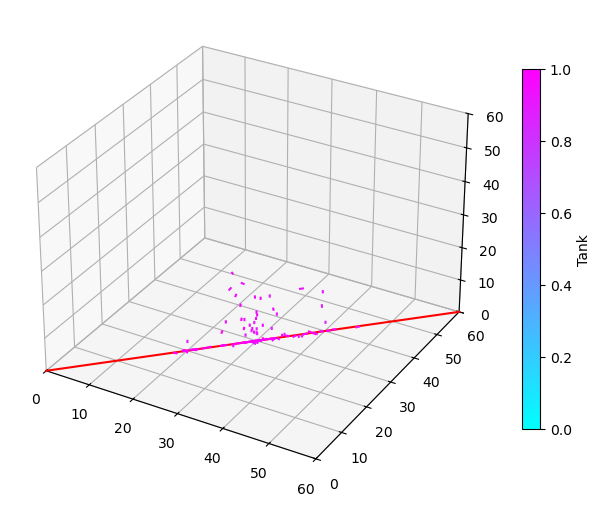

In [8]:
np.random.seed(100)
#initalize data
init_data=np.load('/Users/junheqiao/Downloads/2024_project/data/milling_init/combined.npz')
init_pos=init_data['pos']
init_dir=init_data['dir']
k=np.random.randint(0, len(init_pos))


L = 60
N = 100
Field_of_perception = 270
interior_angle = 0.5*np.radians(Field_of_perception)
eta = 0.05
dt = 0.1
time_step = 10000
s = 3*np.ones(N)
turning_rate = np.radians(40)
rr = 1
dro=0.5
dra=14
ro = rr+dro
ra = ro+dra
dim=3
alpha=0.01
rho=0.05
delta=1
sigma=ra
n_th=6
threshold=0.2
T=50

w_1=2
w_2=0
w_3=1
w_4=0
beta=0.1

tank=np.random.uniform(0.5, 1, N)
time_stayed=np.zeros(N)
status=np.zeros(N)
waiting_time=np.random.exponential(((tank)/(alpha*dt))*0.1)
refueling_time=np.zeros(N)

T_wait=np.ones(N)*tank*50

# pos_array = init_pos[k]+np.array([0,0,15])
pos_array = init_pos[k]
dir_array = init_dir[k]
c_g=np.sum(pos_array,axis=0)/N
c_orignial=np.sum(pos_array,axis=0)/N
fig = plt.figure()

ax = p3.Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

ax.plot([0,L], [0,L], [0,0], color='red')

ax.set_zlim3d(bottom=0, top=L)
ax.set_xlim3d(left=0, right=L)
ax.set_ylim3d(bottom=0, top=L)
quiver = ax.quiver(pos_array[:, 0], pos_array[:, 1], pos_array[:, 2], dir_array[:, 0], dir_array[:, 1], dir_array[:, 2],
                   length=0.5, normalize=True, arrow_length_ratio=0.5)
colors = plt.cm.cool(tank)
quiver.set_color(colors)
norm = Normalize(vmin=0, vmax=1)
cmap = plt.cm.cool
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(mappable, ax=ax, orientation='vertical', label='Tank',shrink=0.75)

ree=[]
tankk=[]
waa=[]
U_1_l=[]
U_2_l=[]
U_3_l=[]
U_4_l=[]
ss=[]
pp=[]
dd=[]
test=[]
def update_quiver(t):
    global pos_array, dir_array, quiver,status, time_stayed, tank, g_t, c_g, refueling_time,T_wait
    status_copy=np.copy(status)
    ss.append(status_copy)
    pos_copy=np.copy(pos_array)
    dir_copy=np.copy(dir_array)
    pp.append(pos_copy)
    dd.append(dir_copy)
    T_wait-=1

    tankk.append(np.copy(tank))
    stay=np.where(status==0)[0]
    leave=np.where(status==1)[0]
    arrive=np.where(status==2)[0]
    back=np.where(status==3)[0]

    agents=np.ones(N)*len(stay)
    status,U_1,U_2,U_3,U_4=exp_U(tank,agents,time_stayed,pos_array,T_wait)
    U_1_l.append(U_1)
    U_2_l.append(U_2)
    U_3_l.append(U_3)
    U_4_l.append(U_4)


    s[arrive]=0
    s[back]=3
    dir_array = update(pos_array, dir_array, rr, ro, ra, turning_rate, L, dim,status)  # ensure update function handles the interactions
    vel_array = s[:,np.newaxis] * dir_array
    new_pos = pos_array + vel_array * dt
    test.append(t)
    for i in range(N):
        
        if status[i]==0:
            for d in range(dim):
                if new_pos[i, d] <= 0 or new_pos[i, d] >= L:
                    dir_array[i, d] *= -1  # Reflect direction
            if new_pos[i, 2] <= ra:
                new_pos[i, 2]=pos_array[i, 2]
                dir_array[i, 2]=0
        elif status[i]==1:
            if new_pos[i, 2] <= 0:
                new_pos[i, 2] = 0
                status[i]=2

        elif status[i]==3:
            # sigma: distance threshold of back to group            

            # if len(stay)<=10:
            #     if np.linalg.norm(c_orignial-new_pos[i]) <= sigma:
            #         status[i]=0
            #         time_stayed[i]=0
            # else:
            #     if np.linalg.norm(c_g-new_pos[i]) <= sigma:
            #         status[i]=0
            #         time_stayed[i]=0
            
            if np.linalg.norm(c_orignial - new_pos[i]) <= sigma:
                status[i] = 0
                time_stayed[i] = 0


            # time_stayed[i]=0
            # status[i]=0



    vel_array = s[:,np.newaxis] * dir_array
    pos_array += vel_array * dt
    pos_array = np.clip(pos_array, 0, L)
    pos_array[leave]=new_pos[leave]

    stay=np.where(status==0)[0]
    leave=np.where(status==1)[0]
    arrive=np.where(status==2)[0]
    back=np.where(status==3)[0]

    
    for i in range(N):
        if T_wait[i] <=0:
            T_wait[i]=tank[i]*T

    #time stayed
    time_stayed[arrive]+=dt
    time_stayed[back]=0
    ree.append(np.copy(time_stayed))
    c_g=np.sum(pos_array,axis=0)/N
    # quiver.set_offsets(pos_array)
    new_seg = np.concatenate((pos_array[:, np.newaxis, :], pos_array[:, np.newaxis, :] + dir_array[:, np.newaxis, :]),
                             axis=1).reshape(N, 2, dim)
    quiver.set_segments(new_seg)
    colors = plt.cm.cool(tank)
    quiver.set_color(colors)
    return quiver


ani = FuncAnimation(fig, update_quiver, frames=time_step, interval=10)
HTML(ani.to_html5_video())

In [13]:
plt.rcParams.update({'font.size': 20})

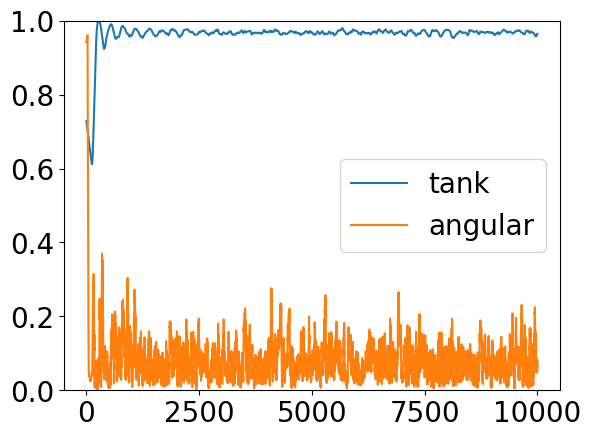

In [14]:
def angular_momentum(pos,dir,status):
    loc=[]
    for i in range(len(pos)) :
        dif=pos[i]-pos[0]
        pos[i][np.where(dif>L/2)[0]]-=L
        pos[i][np.where(dif<-L/2)[0]]+=L
        # if status[i]==0:
        if True:
            loc.append(i)

    N=len(pos[loc])
    c_group=np.sum(pos[loc],axis=0)/N
    r_ic=normalize(pos[loc]-c_group, axis=1, norm='l2')
    cen=np.array([30,30,30])
    diff=cen-c_group
    return np.linalg.norm(np.sum(normalize(np.cross(r_ic,dir[loc])),axis=0))/N
gr_anmo=[]
for i in range(len(tankk)):
    gr_anmo.append(angular_momentum(pp[i],dd[i],ss[i]))

plt.plot(np.arange(len(tankk)),np.average(np.array(tankk),axis=1),label='tank')


plt.plot(np.arange(len(tankk)),gr_anmo, label='angular')
plt.ylim(0,1)
plt.legend()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

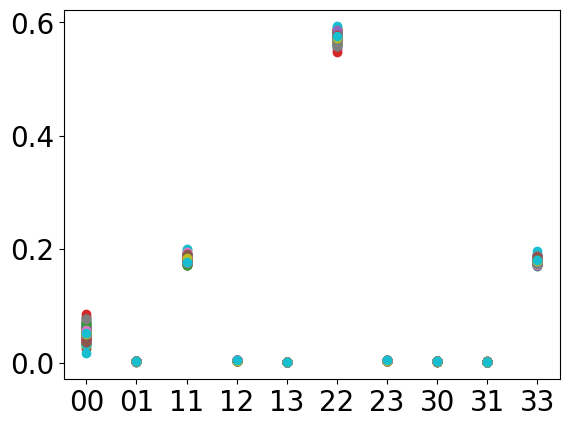

In [15]:
from collections import Counter

def calculate_combination_probabilities(data):
    combinations = [f"{data[i]}{data[i+1]}" for i in range(len(data) - 1)]
    combination_counts = Counter(combination for combination in combinations if combination != "10")
    total_combinations = len(combinations)
    combination_probabilities = {combination: count / total_combinations for combination, count in combination_counts.items()}
    return combination_probabilities

all_probs=[]
for i in range(100):

    combination_probabilities = calculate_combination_probabilities(np.array(ss,dtype=int)[:,i])
    
    # Sort combinations alphabetically for consistent plotting
    sorted_combinations = sorted(combination_probabilities.keys())
    sorted_probs = [combination_probabilities[combination] for combination in sorted_combinations]
    all_probs.append(sorted_probs)

    # Plot the probabilities for the current dataset
    plt.scatter(sorted_combinations, sorted_probs, marker='o', label=f'Dataset {i+1}')

plt.scatter(sorted_combinations, np.average(np.array(all_probs),axis=0), marker='o')